February 20th (2022) Hiroyuki Tako ISHIKAWA

We try to fit an emission spectrum model to the IRD spectra of Barnard's Star (GJ699).  

In [1]:
#You need to download the data of an observed spectrum and a line list of VALD: ...
path_ObsData = '/home/tako/work/gj699_coadded_cr2.dat'
path_ValdLineList = '/home/tako/work/VALD3/vald4214450.gz'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

from exojax.spec.rtransfer import pressure_layer,nugrid
from exojax.utils.instfunc import resolution_to_gaussian_std

from exojax.spec import moldb, atomll, contdb
from exojax.spec import modit, initspec
from exojax.spec import molinfo

Load observed data.

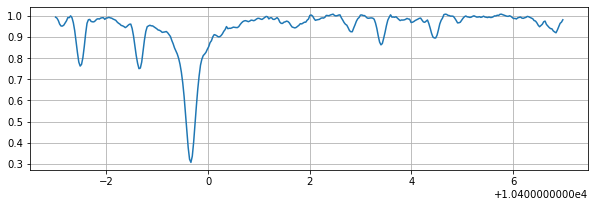

In [4]:
gj699 = np.loadtxt(path_ObsData)

#Set wavelength range
wls, wll = 10398, 10406 

#Trim
gj699t = gj699[np.where((gj699[:,0] >= wls-1.) & (gj699[:,0] <= wll+1.)),:][0]
del(gj699)
wavd = gj699t[:, 0]
nflux = gj699t[::-1,1]
nusd = jnp.array(1.e8/wavd[::-1])

#Plot
plt.figure(figsize=(10,3))
plt.plot(wavd[::-1],nflux)
plt.grid(); plt.show()

Set atmospheric layers, wavenumber points, and instrumantal resolution, for the model.

In [5]:
#Set a model atmospheric layers, wavenumber range for the model, an instrument

NP = 100
Parr, dParr, k = pressure_layer(NP = NP)

Nx = 2000
nus, wav, res = wavenumber_grid(np.min(wavd) - 5.0, np.max(wavd) + 5.0, Nx, unit="AA", xsmode="modit")

Rinst=100000. #instrumental spectral resolution
beta_inst=resolution_to_gaussian_std(Rinst)  #equivalent to beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R)

xsmode assumes ESLOG: mode= modit


Load database of spectral lines and CIA.

In [6]:
#atoms and ions from VALD
adbV = moldb.AdbVald(path_ValdLineList, nus, crit = 1e-100) #The crit is defined just in case some weak lines may cause an error of gammaL of 0... (220219)  
asdb = moldb.AdbSepVald(adbV)

#molecules from exomol
mdbH2O = moldb.MdbExomol('.database/H2O/1H2-16O/POKAZATEL', nus, crit = 1e-50)#,crit = 1e-40)
mdbTiO = moldb.MdbExomol('.database/TiO/48Ti-16O/Toto', nus, crit = 1e-50)#,crit = 1e-50)
mdbOH = moldb.MdbExomol('.database/OH/16O-1H/MoLLIST', nus)
mdbFeH = moldb.MdbExomol('.database/FeH/56Fe-1H/MoLLIST', nus)

#CIA
cdbH2H2 = contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

#molecular mass
molmassH2O = molinfo.molmass("H2O")
molmassTiO = molinfo.molmass("TiO")
molmassOH = molinfo.molmass("OH")
molmassFeH = molinfo.molmass("FeH")
molmassH = molinfo.molmass("H")
molmassH2 = molinfo.molmass("H2")

Reading VALD file
Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
Background atmosphere:  H2
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Reading transition file
.broad is used.
Background atmosphere:  H2
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Reading transition file
.broad is used.
Background atmosphere:  H2
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Reading transition file
.broad is used.
H2-H2


Define some arrays for the model.

In [7]:
#reference pressure for a T-P model
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)

Initialize MODIT.

In [8]:
#Initialization of MODIT (for separate VALD species, and exomol molecules(e.g., FeH))
cnuS, indexnuS, R, pmarray = initspec.init_modit_vald(asdb.nu_lines, nus, asdb.N_usp)
cnu_FeH, indexnu_FeH, R, pmarray = initspec.init_modit(mdbFeH.nu_lines, nus)
cnu_H2O, indexnu_H2O, R, pmarray = initspec.init_modit(mdbH2O.nu_lines, nus)
cnu_OH, indexnu_OH, R, pmarray = initspec.init_modit(mdbOH.nu_lines, nus)
cnu_TiO, indexnu_TiO, R, pmarray = initspec.init_modit(mdbTiO.nu_lines, nus)

#Do not confuse R with Rinst. R is the spectral resolution of the raw spectral model, which should be higher than Rinst, while Rinst is the instrumental spectral resolution.
R > Rinst

True

Set DIT grid matrix (DGM) with assuming typical mixing ratios of H, He, and H2 and sampling the max/min of temperature profiles.

In [9]:
fT = lambda T0,alpha: T0[:,None]*(Parr[None,:]/Pref)**alpha[:,None]
T0_test=np.array([1500.0, 4000.0, 1500.0, 4000.0])
alpha_test=np.array([0.2,0.2,0.05,0.05])
res=0.2

#Assume typical atmosphere
H_He_HH_VMR_ref = [0.1, 0.15, 0.75]
PH_ref = Parr* H_He_HH_VMR_ref[0]
PHe_ref = Parr* H_He_HH_VMR_ref[1]
PHH_ref = Parr* H_He_HH_VMR_ref[2]

#Precomputing dgm_ngammaL
dgm_ngammaL_VALD = modit.setdgm_vald_all(asdb, PH_ref, PHe_ref, PHH_ref, R, fT, res, T0_test, alpha_test)
dgm_ngammaL_FeH = modit.setdgm_exomol(mdbFeH, fT, Parr, R, molmassFeH, res, T0_test, alpha_test)
dgm_ngammaL_H2O = modit.setdgm_exomol(mdbH2O, fT, Parr, R, molmassH2O, res, T0_test, alpha_test) 
dgm_ngammaL_OH = modit.setdgm_exomol(mdbOH, fT, Parr, R, molmassOH, res, T0_test, alpha_test) 
dgm_ngammaL_TiO = modit.setdgm_exomol(mdbTiO, fT, Parr, R, molmassTiO, res, T0_test, alpha_test) 

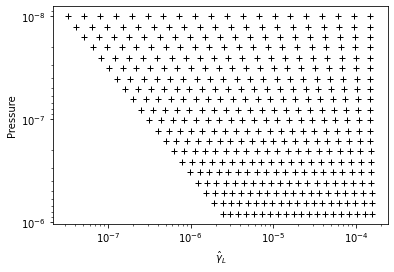

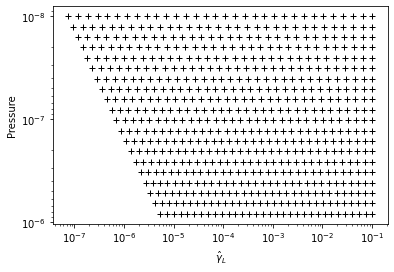

In [10]:
#Try showing the DIT grids.  
from exojax.plot.ditplot import plot_dgmn
plot_dgmn(Parr, dgm_ngammaL_FeH, None, 0, 20)
plot_dgmn(Parr, dgm_ngammaL_VALD[5], None, 0, 20)

Prepare numpyro as a PPL (probabilistic programming language).

In [11]:
from jax import random
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

Construct the model: **the user-defined function "frun"** returns a spectral model.

In [12]:
from exojax.spec.modit import vald_all, xsmatrix_vald, exomol, xsmatrix
from exojax.spec.rtransfer import  dtauVALD, dtauM_mmwl, dtauHminus_mmwl, dtauCIA_mmwl, rtrun
from exojax.spec import planck, response

In [13]:
def frun(T0, alpha, Mp, Rp, u1, u2, RV, vsini, mmw, log_e_H, VMR_H, VMR_H2, VMR_FeH, VMR_H2O, VMR_OH, VMR_TiO, A_Fe, A_Ti, adjust_continuum):
    ga=2478.57730044555*Mp/Rp**2
    Tarr = T0*(Parr/Pref)**alpha
    PH = Parr* VMR_H
    PHe = Parr* (1-VMR_H-VMR_H2)
    PHH = Parr* VMR_H2
    VMR_e = VMR_H*10**log_e_H
    mmw = mmw*ONEARR #mean molecular weight

    #VMR of atoms and ions (+Abundance modification)
    mods_ID = jnp.array([[26,1], [22,1]])
    mods = jnp.array([A_Fe, A_Ti])
    VMR_uspecies = atomll.get_VMR_uspecies(asdb.uspecies, mods_ID, mods)
    VMR_uspecies = VMR_uspecies[:, None]*ONEARR
    
    #Compute delta tau

    #Atom & ions (VALD)
    SijMS, ngammaLMS, nsigmaDlS = vald_all(asdb, Tarr, PH, PHe, PHH, R)
    xsmS = xsmatrix_vald(cnuS, indexnuS, R, pmarray, nsigmaDlS, ngammaLMS, SijMS, nus, dgm_ngammaL_VALD)
    dtauatom = dtauVALD(dParr, xsmS, VMR_uspecies, mmw, ga)

    #FeH
    SijM_FeH, ngammaLM_FeH, nsigmaDl_FeH = exomol(mdbFeH, Tarr, Parr, R, molmassFeH)
    xsm_FeH = xsmatrix(cnu_FeH, indexnu_FeH, R, pmarray, nsigmaDl_FeH, ngammaLM_FeH, SijM_FeH, nus, dgm_ngammaL_FeH)
    dtaum_FeH = dtauM_mmwl(dParr, jnp.abs(xsm_FeH), VMR_FeH*ONEARR, mmw, ga)

    #H2O
    SijM_H2O, ngammaLM_H2O, nsigmaDl_H2O = exomol(mdbH2O, Tarr, Parr, R, molmassH2O)
    xsm_H2O = xsmatrix(cnu_H2O, indexnu_H2O, R, pmarray, nsigmaDl_H2O, ngammaLM_H2O, SijM_H2O, nus, dgm_ngammaL_H2O)
    dtaum_H2O = dtauM_mmwl(dParr, jnp.abs(xsm_H2O), VMR_H2O*ONEARR, mmw, ga) 

    #OH
    SijM_OH, ngammaLM_OH, nsigmaDl_OH = exomol(mdbOH, Tarr, Parr, R, molmassOH)
    xsm_OH = xsmatrix(cnu_OH, indexnu_OH, R, pmarray, nsigmaDl_OH, ngammaLM_OH, SijM_OH, nus, dgm_ngammaL_OH)
    dtaum_OH = dtauM_mmwl(dParr, jnp.abs(xsm_OH), VMR_OH*ONEARR, mmw, ga) 

    #TiO
    SijM_TiO, ngammaLM_TiO, nsigmaDl_TiO = exomol(mdbTiO, Tarr, Parr, R, molmassTiO)
    xsm_TiO = xsmatrix(cnu_TiO, indexnu_TiO, R, pmarray, nsigmaDl_TiO, ngammaLM_TiO, SijM_TiO, nus, dgm_ngammaL_TiO)
    dtaum_TiO = dtauM_mmwl(dParr, jnp.abs(xsm_TiO), VMR_TiO*ONEARR, mmw, ga) 

    #Hminus
    dtau_Hm = dtauHminus_mmwl(nus, Tarr, Parr, dParr, VMR_e*ONEARR, VMR_H*ONEARR, mmw, ga)
    
    #CIA
    dtauc_H2H2 = dtauCIA_mmwl(nus, Tarr, Parr, dParr, VMR_H2*ONEARR, VMR_H2*ONEARR, mmw, ga, cdbH2H2.nucia, cdbH2H2.tcia, cdbH2H2.logac)

    #Summations
    dtau = dtauatom + dtaum_FeH + dtaum_H2O + dtaum_OH + dtaum_TiO + dtau_Hm + dtauc_H2H2
    
    sourcef = planck.piBarr(Tarr, nus)
    F0 = rtrun(dtau, sourcef)
    Frot = response.rigidrot(nus, F0, vsini, u1, u2)
    mu = response.ipgauss_sampling(nusd, nus, Frot, beta_inst, RV)
    mu = mu/jnp.nanmax(mu)*adjust_continuum
    return(mu)

Test plot using frun  
(Referring M and R of GJ699 to Mann et al. (2015); 0.155 M_sun, 0.1863 R_sun)

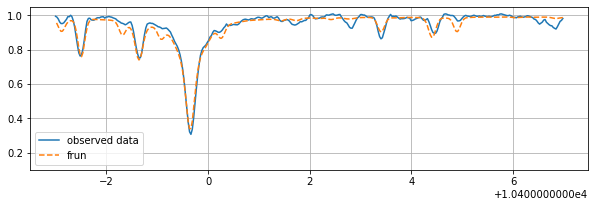

In [14]:
T0 = 3000.
alpha = 0.07
Mp=0.155 *1.99e33/1.90e30
Rp=0.186 *6.96e10/6.99e9
u1=0.0
u2=0.0
RV=0.00
vsini=2.0
mmw=2.33
log_e_H = -4.2
VMR_H = 0.09 
VMR_H2 = 0.77
VMR_FeH = 10**-8
VMR_H2O = 10**-4
VMR_OH = 10**-4
VMR_TiO = 10**-8
A_Fe = 1.5
A_Ti = 1.2
adjust_continuum = 0.99

mu = frun(T0, alpha, Mp, Rp, u1, u2, RV, vsini, \
                     mmw, log_e_H, VMR_H, VMR_H2, \
                     VMR_FeH, VMR_H2O, VMR_OH, VMR_TiO, \
                     A_Fe, A_Ti, adjust_continuum)

plt.figure(figsize = (10, 3))
plt.plot(wavd[::-1], nflux, label = "observed data")
plt.plot(wavd[::-1], mu, label="frun", ls='--')
plt.legend(); plt.grid(); plt.ylim(0.1, 1.05)
plt.show()

Let's define the model for a HMC.

In [15]:
def model_c(y1):
    T0 = numpyro.sample('T0', dist.Uniform(1500.0,4000.0))
    alpha=numpyro.sample('alpha', dist.Uniform(0.01,0.19))
    Mp=0.155 *1.99e33/1.90e30
    Rp=0.186 *6.96e10/6.99e9 
    u1=0.0
    u2=0.0
    RV = numpyro.sample('RV', dist.Uniform(-1.0,1.1))
    vsini = numpyro.sample('vsini', dist.Uniform(0.0, 20.0))
    mmw = numpyro.sample('mmw', dist.Uniform(2.0, 3.0))
    log_e_H = numpyro.sample('log(e/H)', dist.Uniform(-7.0, 3.0))
    VMR_H = numpyro.sample('VMR_H', dist.Uniform(0.0, 0.5))
    VMR_H2 = 0.75
    VMR_FeH = 10**(numpyro.sample('VMR_FeH', dist.Uniform(-12., -6.)))
    VMR_H2O = 10**-4
    VMR_OH = 10**-4 
    VMR_TiO = 10**(numpyro.sample('VMR_TiO', dist.Uniform(-10., -3.)))
    A_Fe = numpyro.sample('mod_A_Fe', dist.Uniform(-10., 10.))
    A_Ti = numpyro.sample('mod_A_Ti', dist.Uniform(-10., 10.))
    adjust_continuum = numpyro.sample('adjust_continuum', dist.Uniform(0.95, 1.05))
    sigma = numpyro.sample('sigma',dist.Exponential(1.0))

    mu = frun(T0, alpha, Mp, Rp, u1, u2, RV, vsini, \
                     mmw, log_e_H, VMR_H, VMR_H2, \
                     VMR_FeH, VMR_H2O, VMR_OH, VMR_TiO, \
                     A_Fe, A_Ti, adjust_continuum)
    numpyro.sample("y1", dist.Normal(mu, sigma), obs=y1)

In [16]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200 #500, 1000
kernel = NUTS(model_c,forward_mode_differentiation=True,max_tree_depth=7)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)

In [ ]:
mcmc.run(rng_key_, y1=nflux)

warmup:  18%|▏| 53/300 [1:40:45<11:21:56, 165.65s/it, 127 steps of size 3.00e-03

Visualize results

dict_keys(['RV', 'T0', 'VMR_FeH', 'VMR_H', 'VMR_TiO', 'adjust_continuum', 'alpha', 'log(e/H)', 'mmw', 'mod_A_Fe', 'mod_A_Ti', 'sigma', 'vsini'])


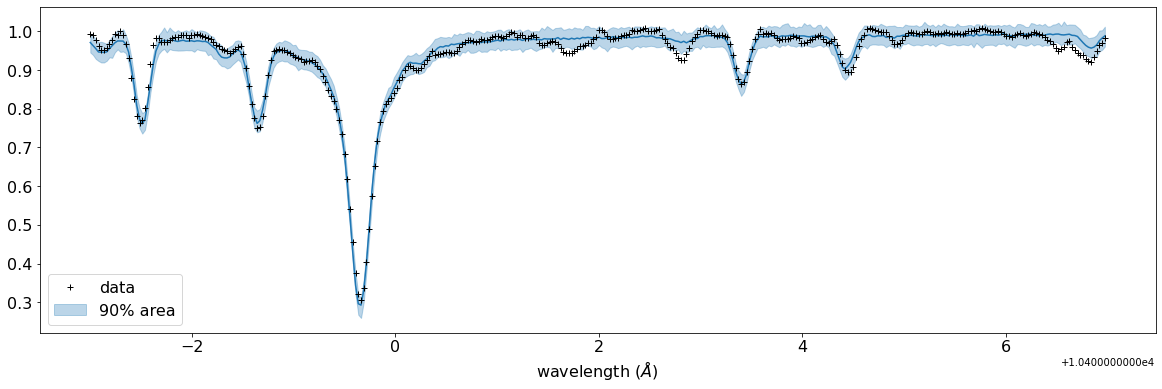

In [27]:
posterior_sample = mcmc.get_samples()
print(posterior_sample.keys())

pred = Predictive(model_c,posterior_sample,return_sites=["y1"])
predictions = pred(rng_key_,y1=None)
median_mu1 = jnp.median(predictions["y1"],axis=0)
hpdi_mu1 = hpdi(predictions["y1"], 0.9)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
ax.plot(wavd[::-1],median_mu1,color="C0")
ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
ax.fill_between(wavd[::-1], hpdi_mu1[0], hpdi_mu1[1], alpha=0.3, interpolate=True,color="C0",label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

In [28]:
import arviz
arviz.rcParams['plot.max_subplots'] = np.sum(np.arange(len(posterior_sample.keys())+1))

refs = {}
refs["T0"] = 3200
refs["alpha"] = 0.1
#refs["Rp"] = 1.9
refs["RV"] = 0.0
refs["vsini"] = 2.0
refs["mmw"] = 2.33
refs['log(e/H)'] = 0.0
refs['VMR_H'] = 0.1
#refs['VMR_H2'] = 0.75
refs['VMR_FeH'] = -9
#refs['VMR_H2O'] = -4
#refs['VMR_OH'] = -4
refs['VMR_TiO'] = -7 
refs["mod_A_Fe"] = 0.0
refs["mod_A_Ti"] = 0.0
refs["adjust_continuum"] = 1.0
refs["sigma"] = 0.02

arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,marginals=True,
               reference_values=refs,reference_values_kwargs={'color':"red", "marker":"o", "markersize":12})
plt.show()

In [29]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                RV      0.10      0.03      0.09      0.04      0.14     27.31      1.05
                T0   1569.79     54.93   1551.43   1505.55   1664.49      7.66      1.18
           VMR_FeH     -6.51      0.08     -6.53     -6.63     -6.36      7.93      1.22
             VMR_H      0.29      0.06      0.31      0.20      0.37      6.77      1.13
           VMR_TiO     -6.71      1.59     -7.15     -8.97     -4.23      2.79      1.93
  adjust_continuum      0.99      0.00      0.99      0.99      0.99     14.56      1.23
             alpha      0.09      0.00      0.09      0.09      0.10     30.49      1.01
          log(e/H)     -4.88      0.27     -4.92     -5.30     -4.48     10.37      1.00
               mmw      2.80      0.09      2.80      2.68      2.95      6.22      1.07
          mod_A_Fe      9.92      0.10      9.97      9.78     10.00      7.93      1.03
          mod_A_Ti  